In [29]:
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import re
import numpy as np
import copy

def getData(folder, filename): #I'm finally using python properly
    rdr = ascii.get_reader(Reader=ascii.Basic)
    rdr.header.splitter.delimiter = ' '
    rdr.data.splitter.delimiter = ' '
    if folder == 'DES_BLINDnoHOSTZ':
        rdr.header.start_line = 12
        rdr.data.start_line = 13
    else:
        rdr.header.start_line = 14
        rdr.data.start_line = 15
    rdr.data.end_line = None
    
    t = rdr.read('%s/%s' % (folder, filename))
    FLT = t['FLT']
    
    MJD = t['MJD']
    IMJD = copy.deepcopy(MJD)
    for i in range(len(IMJD)):
        IMJD[i] = int(IMJD[i])
    UIMJD, indices = np.unique(IMJD, return_index=True)
    
    gFlux = np.array(t['FLUXCAL'][FLT == 'g'])
    rFlux = np.array(t['FLUXCAL'][FLT == 'r'])
    iFlux = np.array(t['FLUXCAL'][FLT == 'i'])
    zFlux = np.array(t['FLUXCAL'][FLT == 'z'])
    gErr = np.array(t['FLUXCALERR'][FLT == 'g'])
    rErr = np.array(t['FLUXCALERR'][FLT == 'r'])
    iErr = np.array(t['FLUXCALERR'][FLT == 'i'])
    zErr = np.array(t['FLUXCALERR'][FLT == 'z'])
    maxL = max(len(gFlux),len(rFlux), len(iFlux), len(zFlux))
    
    ts = np.zeros((50, 9))
        
    for i in range(len(indices)-1):
        start = indices[i]
        end = indices[i+1]
        TMJD = 0
        for j in range(start,end):
            flux = t['FLUXCAL'][j]
            error = t['FLUXCALERR'][j]
            TMJD += t['MJD'][j]
            if FLT[j] =='g':
                ts[i,1] = flux
                ts[i,5] = error
            elif FLT[j] =='r':
                ts[i,2] = flux
                ts[i,6] = error
            elif FLT[j] =='i':
                ts[i,3] = flux
                ts[i,7] = error
            else:  # FLT[j] =='z'
                ts[i,4] = flux
                ts[i,8] = error
        ts[i,0] = TMJD/(end-start)
            
        
    return ts
    
def getInfo(info, file):
    for line in file:
        if line.startswith('%s' % info):
            return line[(len(info)+2)::] #might have extra spaces in front and it's a string
    return None

folder= 'DES_BLINDnoHOSTZ'

#folder: no vs +
#infoL: info list. eg. 'SNID', 'SNTYPE', 'FILTERS', 'RA', 'DECL', 'FAKE', 'MWEBV', ETC.
#totalNum: total number of supernovae in the foler. Might be improved to automatically going through all files in a folder
if folder == 'DES_BLINDnoHOSTZ':
    colName = 'DES_SN000018.DAT'
    totalNum = 18347
    infoL = ['SURVEY','SNID', 'SNTYPE', 'FILTERS', 'RA', 'DECL', 'FAKE', 'MWEBV', 'REDSHIFT_SPE','NOBS', 'NVAR']
else:
    colName = 'DES_SN000041.DAT'
    totalNum = 18320
    infoL = ['SURVEY','SNID','SNTYPE','FILTERS','RA','DECL','FAKE','MWEBV','REDSHIFT_SPE','HOST_GALAXY_GALID','HOST_GALAXY_PHOTO-Z','NOBS','NVAR']

list = ascii.read('%s/%s.LIST' % (folder, folder), data_start = 0)
table = dict()
for i in infoL:
    table[i] = []
table['FILENAME'] = []
table['DATA'] = []
#table
for i in range(totalNum):
    with open(folder + '/' + list[colName][i]) as f:
        table['FILENAME'] += [list[colName][i]]
        table['DATA'] += [getData(folder, list[colName][i])]
        for j in infoL:
            table[j] += [getInfo(j, f)]
infoList = [table['FILENAME']]
for i in infoL:
    infoList += [table[i]]
infoList += [table['DATA']]

In [30]:
output = Table(infoList, names = ['FILENAME']+infoL+['DATA'])

In [31]:
output

FILENAME,SURVEY,SNID,SNTYPE,FILTERS,RA,DECL,FAKE,MWEBV,REDSHIFT_SPE,NOBS,NVAR,"DATA [50,9]"
str16,str7,str12,str5,str6,str21,str20,str35,str23,str25,str5,str3,float64
DES_SN000018.DAT,DES,18,-9,griz,34.500000 deg,-5.500000 deg,3 (=> BLIND-TEST simulation),0.0227 MW E(B-V),-9.0000 +- 9.0000,118,5,56187.18175 .. 0.0
DES_SN000050.DAT,DES,50,-9,griz,36.750000 deg,-4.500000 deg,3 (=> BLIND-TEST simulation),0.0283 MW E(B-V),-9.0000 +- 9.0000,16,5,56318.07666666667 .. 0.0
DES_SN000051.DAT,DES,51,1,griz,52.500000 deg,-27.500000 deg,3 (=> BLIND-TEST simulation),0.0097 MW E(B-V),0.5177 +- 0.0050,121,5,56194.2795 .. 0.0
DES_SN000063.DAT,DES,63,-9,griz,34.500000 deg,-5.500000 deg,3 (=> BLIND-TEST simulation),0.0227 MW E(B-V),-9.0000 +- 9.0000,115,5,56177.19925 .. 0.0
DES_SN000064.DAT,DES,64,-9,griz,48.000000 deg,0.000000 deg,3 (=> BLIND-TEST simulation),0.0713 MW E(B-V),-9.0000 +- 9.0000,92,5,56194.22166666666 .. 0.0
DES_SN000096.DAT,DES,96,-9,griz,34.500000 deg,-5.500000 deg,3 (=> BLIND-TEST simulation),0.0227 MW E(B-V),-9.0000 +- 9.0000,104,5,56215.172 .. 0.0
DES_SN000122.DAT,DES,122,-9,griz,34.500000 deg,-5.500000 deg,3 (=> BLIND-TEST simulation),0.0227 MW E(B-V),-9.0000 +- 9.0000,11,5,56333.047 .. 0.0
DES_SN000124.DAT,DES,124,-9,griz,48.000000 deg,0.000000 deg,3 (=> BLIND-TEST simulation),0.0713 MW E(B-V),-9.0000 +- 9.0000,95,5,56178.25 .. 0.0
DES_SN000156.DAT,DES,156,-9,griz,36.750000 deg,-4.500000 deg,3 (=> BLIND-TEST simulation),0.0283 MW E(B-V),-9.0000 +- 9.0000,87,5,56178.199250000005 .. 0.0


In [35]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/apple/Library/Python/3.6/lib/python/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'copy', 'table']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


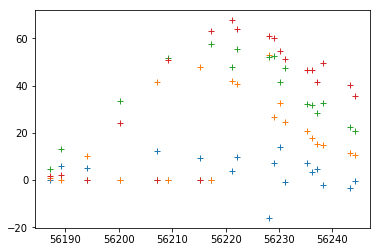

In [55]:
plot(output['DATA'][0][:20,0], output['DATA'][0][:20,1],'+')
plot(output['DATA'][0][:20,0], output['DATA'][0][:20,2],'+')
plot(output['DATA'][0][:20,0], output['DATA'][0][:20,3],'+')
plot(output['DATA'][0][:20,0], output['DATA'][0][:20,4],'+')

In [68]:
std(output['DATA'][:,0:20,1])

56.86717604825095

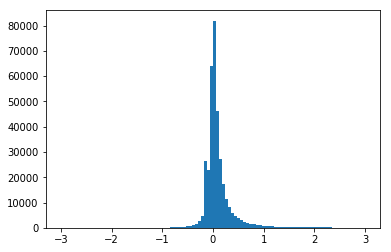

In [78]:
m = output['DATA'][:,:,1].flatten() != 0
hist(output['DATA'][:,:,1].flatten()[m]/58,100,range=[-3,3]);

In [76]:
std(output['DATA'][:,:,1].flatten()[m])

58.31917073825026

In [58]:
output['DATA'][0][:20,0]

array([56187.18175, 56189.17175, 56194.125  , 56200.168  , 56207.164  ,
       56209.203  , 56215.172  , 56217.1715 , 56221.1395 , 56222.12775,
       56228.1055 , 56229.1395 , 56230.121  , 56231.1385 , 56235.168  ,
       56236.18175, 56237.20225, 56238.214  , 56243.22175, 56244.1985 ])

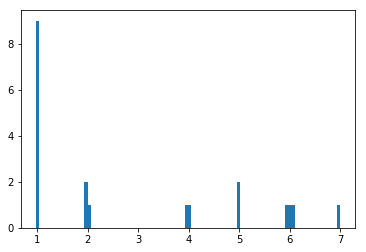

In [57]:
hist(output['DATA'][0][1:21,0]-output['DATA'][0][0:20,0],100);

In [59]:
output['DATA'][0][1:21,0]-output['DATA'][0][0:20,0]

array([1.99   , 4.95325, 6.043  , 6.996  , 2.039  , 5.969  , 1.9995 ,
       3.968  , 0.98825, 5.97775, 1.034  , 0.9815 , 1.0175 , 4.0295 ,
       1.01375, 1.0205 , 1.01175, 5.00775, 0.97675, 1.01525])

In [53]:
output['DATA'][0][:,5]

array([ 1.703,  9.761,  3.774,  0.   ,  2.307,  0.   ,  1.626,  0.   ,
        4.495,  6.427, 26.12 , 30.75 ,  9.32 ,  7.696,  3.792,  2.006,
        3.444,  2.975,  1.692,  1.784,  4.788,  2.001,  1.753,  8.081,
        0.   ,  3.959,  0.   ,  2.033,  0.   ,  0.   ,  3.404,  0.   ,
       11.89 ,  1.58 ,  1.644,  0.   ,  5.96 ,  0.   ,  2.914,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ])

In [60]:
output.write('table_test1.fits')